In [8]:
%%capture
import os
import sys

import numpy as np
import pandas as pd
import pandas_datareader.data as web

!pip install sktime==0.6.1
import lightgbm as lgb
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.forecasting.compose import (TransformedTargetForecaster,
                                        make_reduction)
from sktime.forecasting.model_selection import (ExpandingWindowSplitter,
                                                ForecastingGridSearchCV)
from sktime.utils.plotting import plot_series

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error


sns.set()
plt.style.use('bmh')

In [2]:
df = pd.read_csv('/content/drive/MyDrive/VDT2022/mini-project/stroke_recovery_dataset/protocol/sb01.csv')
cols = ['counts', 'speed']
data_df = df.loc[df.index, cols]
data_df = data_df.interpolate()

In [3]:
TEST_LEN = 92

In [4]:
counts_y = pd.Series(data_df.counts)
counts_y.index = [i for i in range(366)]

counts_train_data, counts_test_data = counts_y.iloc[:-TEST_LEN], counts_y.iloc[-TEST_LEN:]

In [5]:
speed_y = pd.Series(data_df.speed)
speed_y.index = [i for i in range(366)]

speed_train_data, speed_test_data = speed_y.iloc[:-TEST_LEN], speed_y.iloc[-TEST_LEN:]

In [6]:
def plot_forecast(series_train, series_test, forecast, forecast_int=None):
    rmse = mean_squared_error(series_test, forecast)**0.5
    mae = mean_absolute_error(series_test, forecast)
    mape = mean_absolute_percentage_error(series_test, forecast)

    plt.figure(figsize=(12, 6))
    plt.title(f"RMSE: {rmse:.6f}, MAE: {mae:.6f}, MAPE: {mape:.6f}", size=18)
    series_train.plot(label="train", color="b")
    series_test.plot(label="test", color="g")
    forecast.index = series_test.index
    forecast.plot(label="forecast", color="r")
    if forecast_int is not None:
        plt.fill_between(
            series_test.index,
            forecast_int["lower"],
            forecast_int["upper"],
            alpha=0.05,
            color="dimgray",
        )
    plt.legend(prop={"size": 16})
    plt.show()

    return rmse, mae, mape

In [9]:
def grid_serch_forecaster(train, test, forecaster, param_grid):

    # Grid search on window_length
    cv = ExpandingWindowSplitter(initial_window=int(len(train) * 0.7))
    gscv = ForecastingGridSearchCV(
        forecaster, strategy="refit", cv=cv, param_grid=param_grid
    )
    gscv.fit(train)
    print(f"best params: {gscv.best_params_}")

    # forecasting
    fh = np.arange(len(test)) + 1
    y_pred = gscv.predict(fh=fh)
    rmse, mae, mape = plot_forecast(train, test, y_pred)

    return rmse, mae, mape

In [10]:
def create_forecaster_w_desesonalizer(sp=3, degree=1):

    # creating forecaster with LightGBM
    regressor = lgb.LGBMRegressor()
    forecaster = TransformedTargetForecaster(
        [
            ("deseasonalize", Deseasonalizer(model="multiplicative", sp=sp)),
            ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=degree))),
            (
                "forecast",
                make_reduction(regressor, window_length=2, strategy="recursive"),
            ),
        ]
    )

    return forecaster

best params: {'forecast__window_length': 15}


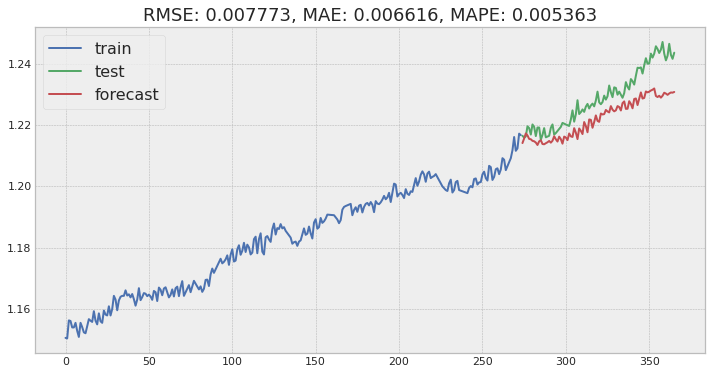

In [11]:
speed_lightgbm_forecaster = create_forecaster_w_desesonalizer()
param_grid = {"forecast__window_length": [15]}

speed_lgb_rmse, speed_lgb_mae, speed_lgb_mape = grid_serch_forecaster(
    speed_train_data, speed_test_data, speed_lightgbm_forecaster, param_grid
)

best params: {'forecast__window_length': 2}


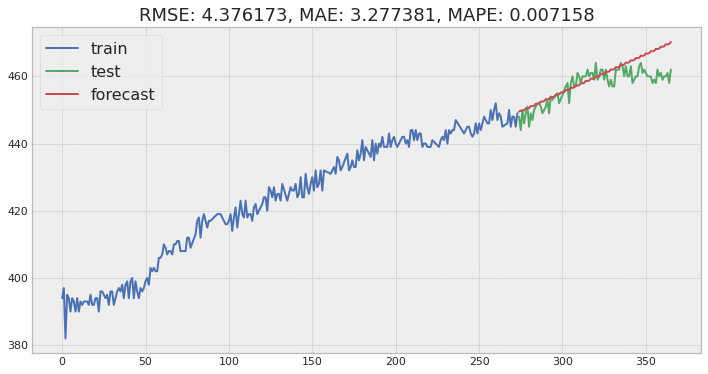

In [12]:
counts_lightgbm_forecaster = create_forecaster_w_desesonalizer()
param_grid = {"forecast__window_length": [2,4,6,8,10]}

counts_lgb_rmse, counts_lgb_mae, counts_lgb_mape = grid_serch_forecaster(
    counts_train_data, counts_test_data, counts_lightgbm_forecaster, param_grid
)